<a href="https://colab.research.google.com/github/spexdj/Data_Science_II_Machine_Learning/blob/main/EntrenamientoyOptimizaci%C3%B3n_ProyectoFinal_Licastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# üìä Proyecto: Modelo Multivariado de Predicci√≥n de Ventas Totales

## 1. Presentaci√≥n

En este an√°lisis, buscamos responder en qu√© medida los descuentos ofrecidos en una tienda, junto con otras variables comerciales como la categor√≠a del producto, el segmento del cliente o la prioridad del pedido, afectan el monto total de venta (`Sales.Total`). Este estudio ser√° de utilidad para √°reas de **marketing**, **finanzas** y **operaciones**, interesadas en entender los factores que m√°s influyen en los ingresos y optimizar estrategias comerciales sin sacrificar rentabilidad.

---

## 2. Formulaci√≥n del problema como ML

**Problema principal:**  
¬øCu√°nto influyen los descuentos y otras variables clave sobre el monto de venta total?

**Tipo de problema:**  
Regresi√≥n supervisada (predictiva)

**Variable objetivo:** `Sales.Total`  
**Variables explicativas:**  
- `Discount`  
- `Quantity`  
- `Year`  
- `Order_Priority`  
- `Segment`  
- `Category`  
- `Sub.Category`  
- Combinaci√≥n: `Discount x Quantity`


In [2]:
# 1. Importaci√≥n de librer√≠as necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# 2. Carga de datos
url = "https://raw.githubusercontent.com/spexdj/Data_Science_II_Machine_Learning/refs/heads/main/superstore3.csv"
df = pd.read_csv(url, encoding='latin1', on_bad_lines='skip')

In [4]:
# 3. Renombrar columnas con espacios o caracteres especiales
df.rename(columns={
    "Order Priority": "Order.Priority",
    "Sub-Category": "Sub.Category"
}, inplace=True)

In [5]:
# 4. Conversi√≥n de columnas num√©ricas que vienen como texto
df["Discount"] = df["Discount"].astype(str).str.replace("%", "").astype(float) / 100
df["Sales.Total"] = df["Sales.Total"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)

In [6]:
# 5. Verificaci√≥n de inconsistencias y valores extremos
print("Valores con descuento mayor al 100%:")
print(df[df["Discount"] > 1])

print("\nVentas totales at√≠picas:")
print(df[df["Sales.Total"] > df["Sales.Total"].quantile(0.99)])

Valores con descuento mayor al 100%:
Empty DataFrame
Columns: [Customer.ID, Customer.Name, Category, City, Country, Discount, Market, Order.Date, Order.Time, Order.ID, Order.Priority, Product.ID, Product.Name, Sales.Price, Quantity, Region, ItemsSale.Count, Sales.Total, Segment, Ship.Date, Ship_Time, Ship.Mode, Shipping.Cost, State, Sub.Category, Year]
Index: []

[0 rows x 26 columns]

Ventas totales at√≠picas:
      Customer.ID       Customer.Name         Category           City  \
503     JK-152054        Jamie Kunitz  Office Supplies  San Francisco   
803     RW-195404         Rick Wilson  Office Supplies      Brentwood   
1137    JD-161504    Justin Deggeller  Office Supplies  New York City   
1146    DJ-136304         Doug Jacobs  Office Supplies  New York City   
1742    YC-218954      Yoseph Carroll  Office Supplies         Newark   
...           ...                 ...              ...            ...   
50987   IM-150554       Ionia McGrath       Technology  San Francisco   
5

In [7]:
# 6. Selecci√≥n de variables relevantes para el an√°lisis
variables = ["Discount", "Quantity", "Year", "Order.Priority", "Segment", "Category", "Sub.Category", "Sales.Total"]
df_model = df[variables].dropna()

In [8]:
# 7. Feature engineering: crear variable combinada entre descuento y cantidad
df_model["Discount_x_Quantity"] = df_model["Discount"] * df_model["Quantity"]

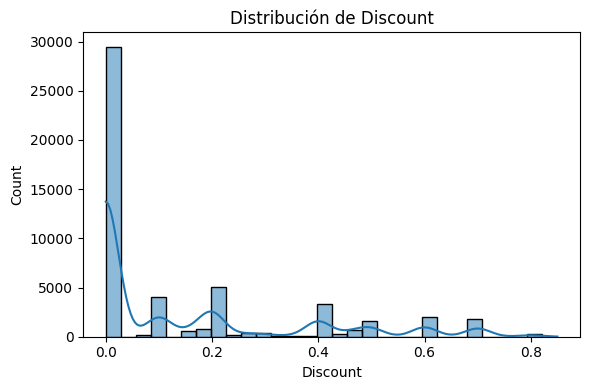

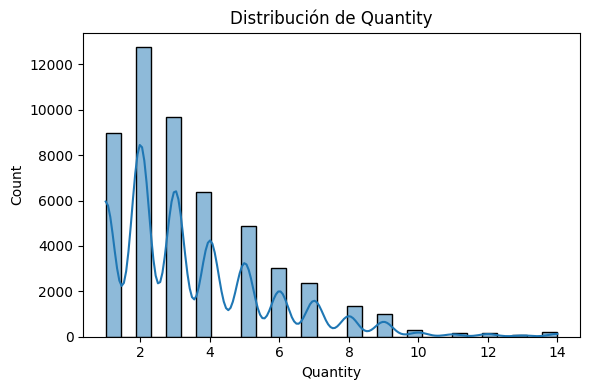

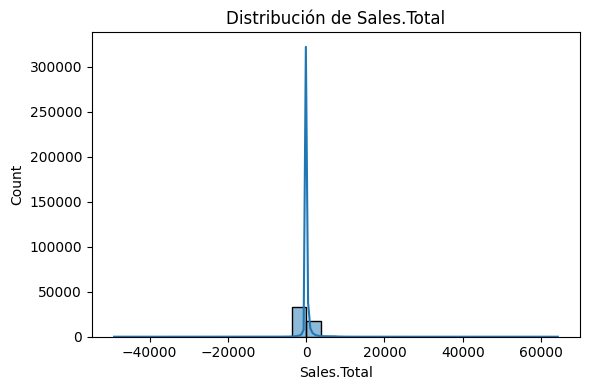

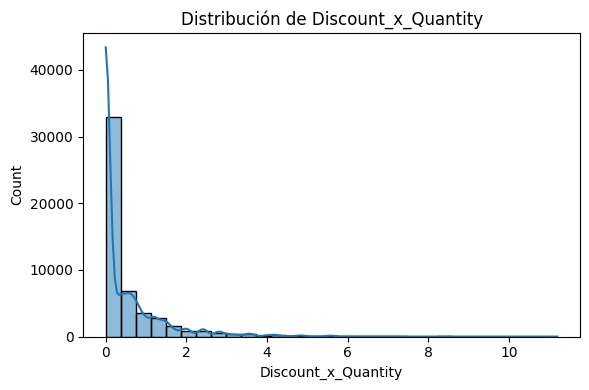

In [9]:
# 8. An√°lisis exploratorio univariado
num_vars = ["Discount", "Quantity", "Sales.Total", "Discount_x_Quantity"]

for var in num_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_model[var], bins=30, kde=True)
    plt.title(f"Distribuci√≥n de {var}")
    plt.tight_layout()
    plt.show()

#üìä Distribuciones num√©ricas (histogramas + KDE)
Discount:
- La mayor√≠a de los descuentos aplicados son cercanos a 0, lo que indica que en la mayor√≠a de las √≥rdenes no se aplica descuento o es muy bajo.
- Hay picos en valores espec√≠ficos como 0.1, 0.2, etc., lo que sugiere que se aplican rangos fijos de descuentos preestablecidos.
- Se observa una fuerte asimetr√≠a hacia la izquierda, t√≠pica en promociones aplicadas solo en ciertos productos o eventos.

Quantity:
- La cantidad de unidades por orden sigue una distribuci√≥n sesgada hacia la izquierda, siendo lo m√°s com√∫n comprar entre 1 y 4 unidades.
- Hay un patr√≥n discreto (enteros), como es l√≥gico para variables de cantidad.
- A partir de 10 unidades la frecuencia disminuye significativamente.

Sales.Total:
- Las ventas totales tienen una distribuci√≥n fuertemente asim√©trica, con presencia de valores negativos (probablemente devoluciones o errores).
- El grueso de las ventas est√° concentrado cerca de 0, lo que podr√≠a estar indicando ventas de bajo valor.
- Existen algunos valores extremadamente altos, posiblemente outliers.

Discount x Quantity
- Esta variable combinada permite visualizar la interacci√≥n entre descuento y volumen.
- La mayor√≠a de los valores se concentran cerca de 0, reflejando pedidos peque√±os con poco o ning√∫n descuento.
- Su distribuci√≥n tambi√©n es asim√©trica, con una larga cola derecha (grandes pedidos con alto descuento).


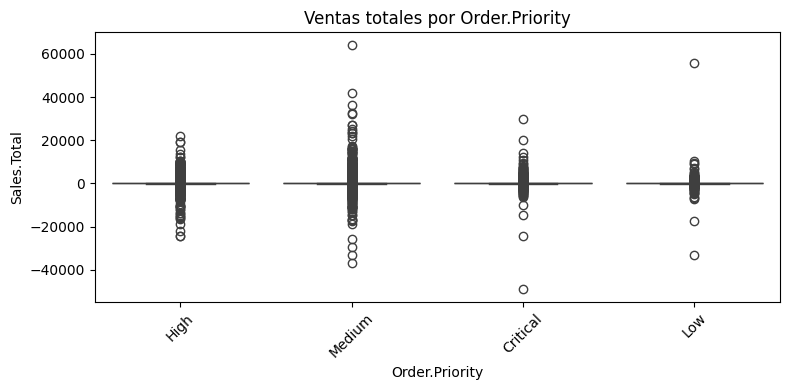

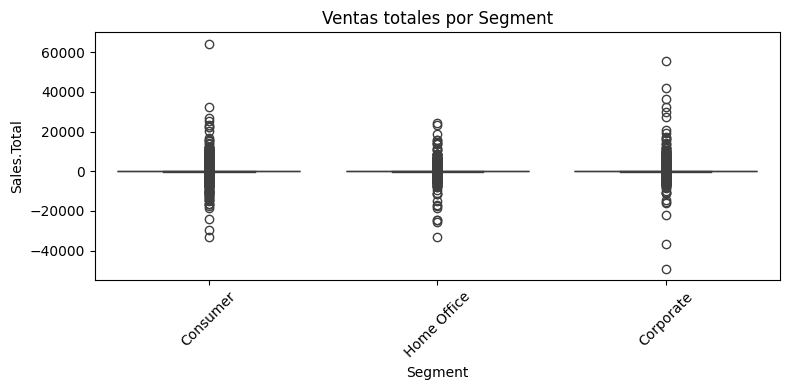

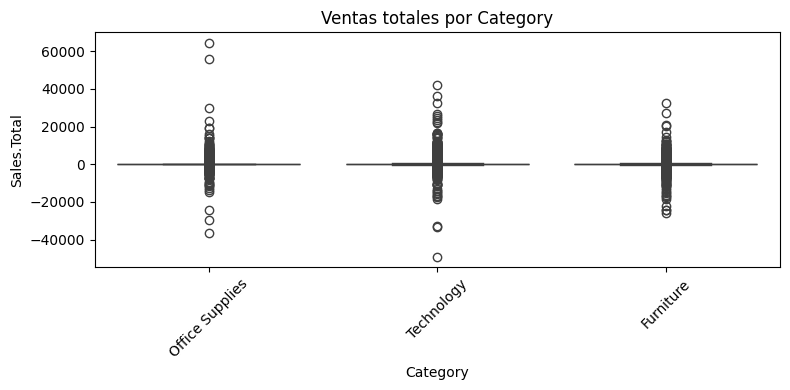

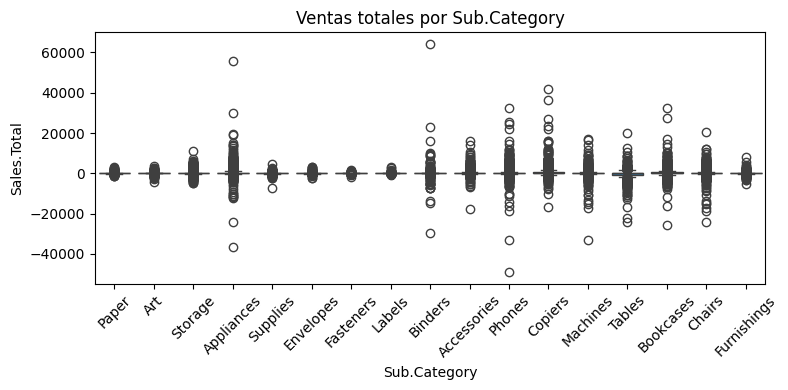

In [10]:
# 9. An√°lisis de variables categ√≥ricas vs ventas (boxplots)
cat_vars = ["Order.Priority", "Segment", "Category", "Sub.Category"]

for var in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_model, x=var, y="Sales.Total")
    plt.title(f"Ventas totales por {var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#üì¶ Distribuci√≥n de ventas por categor√≠as (boxplots)

Order.Priority:
- No se observan diferencias significativas en la mediana de ventas entre prioridades de pedido.
- Las distribuciones son similares, con alta cantidad de outliers en todos los casos.
- Esto podr√≠a indicar que la prioridad de pedido no tiene una relaci√≥n directa con el monto de ventas.

Segment:
- Los tres segmentos presentan una distribuci√≥n similar en ventas, pero "Corporate" muestra una leve mayor dispersi√≥n.
- Se evidencian muchos valores extremos tanto positivos como negativos.
- Puede no ser un diferenciador tan fuerte en t√©rminos de ventas, pero aporta informaci√≥n contextual.

Category:
- La categor√≠a "Technology" muestra mayor variabilidad en las ventas, posiblemente asociada a productos de alto valor.
- "Office Supplies" y "Furniture" tienen menor dispersi√≥n y m√°s valores negativos.

Sub.Category:
- Se observa gran cantidad de subcategor√≠as con comportamiento muy disperso.
- Algunas como "Copiers" o "Phones" tienen valores mucho m√°s altos que el resto, indicando productos de alto valor.
- Esta granularidad es √∫til para segmentar estrategias de pricing o promociones.



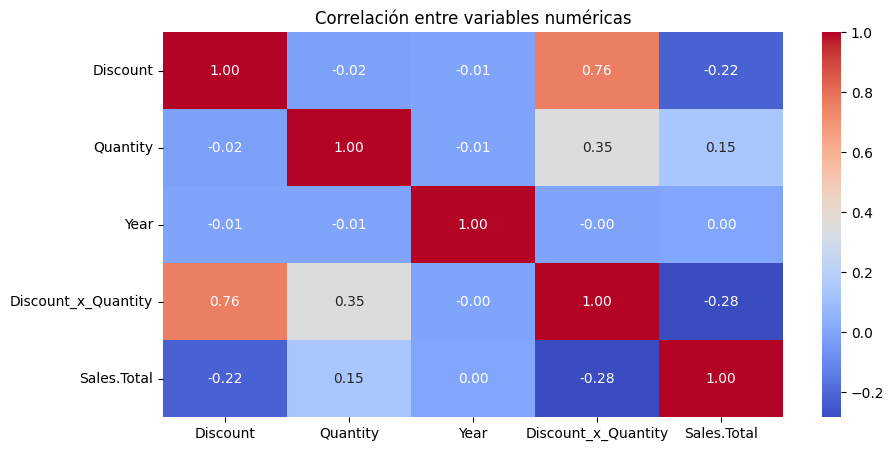

In [11]:
# 10. Heatmap de correlaci√≥n entre variables num√©ricas
plt.figure(figsize=(10, 5))
sns.heatmap(df_model[["Discount", "Quantity", "Year", "Discount_x_Quantity", "Sales.Total"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlaci√≥n entre variables num√©ricas")
plt.show()

#üî• Correlaci√≥n entre variables num√©ricas (Heatmap)
- `Discount` y `Discount_x_Quantity` est√°n altamente correlacionadas (r=0.76), como se esperaba por construcci√≥n.
- `Sales.Total` muestra correlaciones negativas con `Discount` y `Discount_x_Quantity`, lo que podr√≠a indicar que mayores descuentos no necesariamente implican mayores ingresos.
- `Quantity` tiene leve correlaci√≥n positiva con las ventas, lo que sugiere que el volumen tiene algo m√°s de peso.



In [12]:
# 11. Divisi√≥n de datos para entrenamiento
X = df_model.drop("Sales.Total", axis=1)
y = df_model["Sales.Total"]

In [13]:
# 12. Definici√≥n de variables num√©ricas y categ√≥ricas
numeric_features = ["Discount", "Quantity", "Year", "Discount_x_Quantity"]
categorical_features = ["Order.Priority", "Segment", "Category", "Sub.Category"]

In [14]:
# 13. Preprocesador combinado: escalar + codificar
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


In [15]:
# 14. Modelos a evaluar
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


=== Random Forest ===
R¬≤: 0.0808
RMSE: 1097.19
MAE: 291.32
R¬≤ promedio CV (5-fold): -0.1656


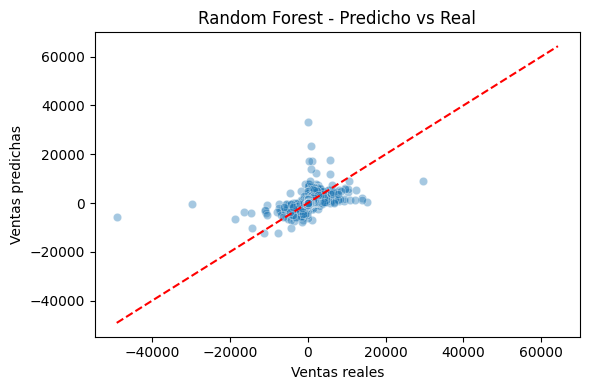


=== Gradient Boosting ===
R¬≤: 0.3036
RMSE: 955.00
MAE: 277.99
R¬≤ promedio CV (5-fold): 0.1960


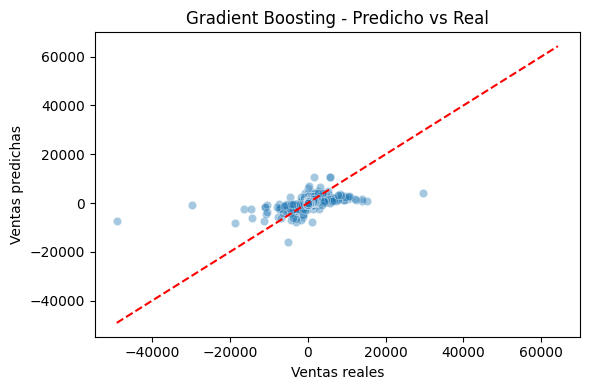

In [16]:
# 15. Evaluaci√≥n de modelos con split y cross-validation
for name, model in models.items():
    print(f"\n=== {name} ===")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # Divisi√≥n de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenamiento
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # M√©tricas con hold-out
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R¬≤: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    # Cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    print(f"R¬≤ promedio CV (5-fold): {scores.mean():.4f}")

    # Gr√°fico de predicciones
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.title(f"{name} - Predicho vs Real")
    plt.xlabel("Ventas reales")
    plt.ylabel("Ventas predichas")
    plt.tight_layout()
    plt.show()

#üìà Predicci√≥n vs Real - Modelos

Random Forest:
- El modelo presenta un bajo desempe√±o predictivo (R¬≤ ‚âà 0.08), indicando que no est√° capturando bien la variabilidad de los datos.
- El RMSE y MAE son altos en relaci√≥n a la escala de ventas.
- El gr√°fico muestra alta concentraci√≥n en valores bajos, con algunas predicciones fuera de rango.

Gradient Boosting:
- Mejora notable respecto a Random Forest, con R¬≤ ‚âà 0.30.
- Tambi√©n mejora en RMSE y MAE, mostrando un ajuste m√°s razonable.
- Aunque sigue existiendo concentraci√≥n alrededor de los valores bajos, se nota mejor alineaci√≥n con la diagonal esperada.




In [17]:
# 16. Optimizaci√≥n con GridSearchCV para Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10, None]
}

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nüîß Mejores par√°metros Random Forest:")
print(grid_search.best_params_)
print("RMSE CV (GridSearch):", -grid_search.best_score_)


üîß Mejores par√°metros Random Forest:
{'regressor__max_depth': 10, 'regressor__n_estimators': 50}
RMSE CV (GridSearch): 1007.3005848391364


## 17. Conclusiones
- La variable `Discount` presenta una correlaci√≥n negativa con `Sales.Total` (-0.22), lo que sugiere que mayores descuentos no necesariamente incrementan las ventas. Esto se confirma tambi√©n en la combinaci√≥n `Discount x Quantity`, que muestra una correlaci√≥n a√∫n m√°s negativa (-0.28) con las ventas.
- El an√°lisis de boxplots por categor√≠a, segmento y prioridad no revela diferencias sustanciales en los montos de ventas, pero s√≠ deja ver una fuerte presencia de outliers, lo que indica una alta variabilidad en los valores de ventas sin un patr√≥n categ√≥rico claro.
- Los histogramas mostraron una distribuci√≥n altamente sesgada en la mayor√≠a de las variables, especialmente `Sales.Total`, con valores extremos tanto negativos como positivos, lo cual afecta la predicci√≥n.
- El modelo de **Random Forest** tuvo un desempe√±o bajo (R¬≤ ‚âà 0.08 y RMSE ‚âà 1097), mientras que **Gradient Boosting** logr√≥ mejorar los resultados significativamente (R¬≤ ‚âà 0.30 y RMSE ‚âà 955).
- En t√©rminos generales, **los modelos de regresi√≥n utilizados no alcanzan un nivel de precisi√≥n alto**, lo cual puede deberse a la alta dispersi√≥n, presencia de valores extremos, y posiblemente a variables relevantes no incluidas en el modelo.


#-Seg√∫n los comentarios y devoluciones del tutor, se procede a realizar una segunda alternativa de an√°lisis bajo la temporalidad de los datos-

## 18. Predicci√≥n de ventas en funci√≥n del tiempo

En esta secci√≥n se aborda el problema desde una perspectiva temporal. Se agruparon las ventas por mes y se entren√≥ un modelo de regresi√≥n para predecir los valores futuros de `Sales.Total` en funci√≥n del √≠ndice temporal.

El conjunto de entrenamiento se construy√≥ con el 80% de los primeros per√≠odos y el test con el 20% restante, replicando un escenario real de forecasting.

Esto permite evaluar si existe un patr√≥n temporal en las ventas y c√≥mo se desempe√±a el modelo al predecir per√≠odos futuros.



üïí Modelo Temporal (Ventas Mensuales)
R¬≤: -0.0056
RMSE: 30942.73


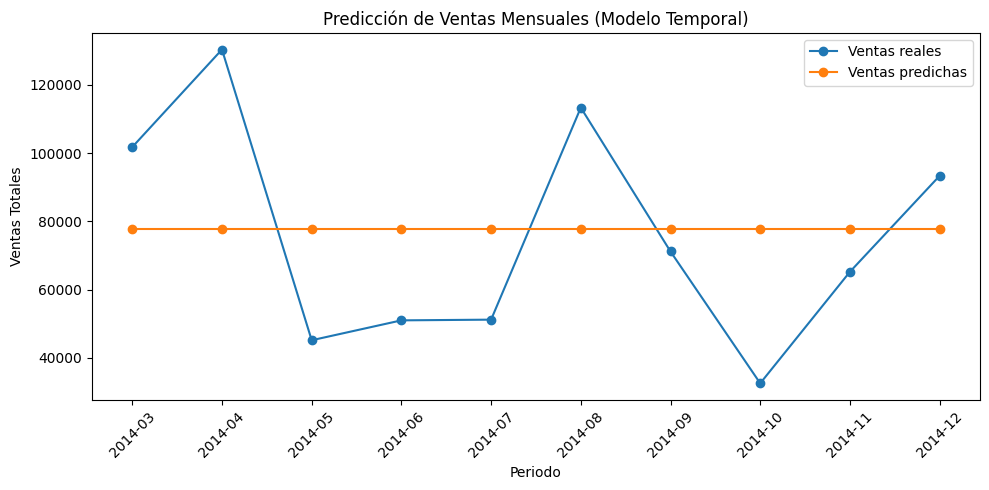

In [18]:
# 18. An√°lisis temporal alternativo (forecasting de ventas mensuales)

# Asegurarse de que la fecha est√© en formato datetime
df["Order.Date"] = pd.to_datetime(df["Order.Date"], errors='coerce')

# Crear columnas de a√±o y mes
df["Order_Year"] = df["Order.Date"].dt.year
df["Order_Month"] = df["Order.Date"].dt.month
df["YearMonth"] = df["Order.Date"].dt.to_period("M")

# Agrupar por mes: total de ventas mensuales
df_monthly = df.groupby("YearMonth")["Sales.Total"].sum().reset_index()
df_monthly["YearMonth"] = df_monthly["YearMonth"].astype(str)

# Crear variable temporal como n√∫mero (para regresi√≥n simple)
df_monthly["TimeIndex"] = range(len(df_monthly))

# Separar en train (80%) y test (20%) respetando el orden temporal
cutoff = int(len(df_monthly) * 0.8)
train = df_monthly.iloc[:cutoff]
test = df_monthly.iloc[cutoff:]

# Variables
X_train = train[["TimeIndex"]]
y_train = train["Sales.Total"]
X_test = test[["TimeIndex"]]
y_test = test["Sales.Total"]

# Entrenar modelo
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# M√©tricas
from sklearn.metrics import mean_squared_error, r2_score

r2_t = r2_score(y_test, y_pred)
rmse_t = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nüïí Modelo Temporal (Ventas Mensuales)")
print("R¬≤:", round(r2_t, 4))
print("RMSE:", round(rmse_t, 2))

# Gr√°fico real vs predicho
plt.figure(figsize=(10, 5))
plt.plot(test["YearMonth"], y_test, label="Ventas reales", marker='o')
plt.plot(test["YearMonth"], y_pred, label="Ventas predichas", marker='o')
plt.xticks(rotation=45)
plt.title("Predicci√≥n de Ventas Mensuales (Modelo Temporal)")
plt.xlabel("Periodo")
plt.ylabel("Ventas Totales")
plt.legend()
plt.tight_layout()
plt.show()

> üîç El modelo temporal basado √∫nicamente en la variable `TimeIndex` no logra capturar un patr√≥n de comportamiento en las ventas mensuales. Esto se refleja en un valor de R¬≤ negativo y en predicciones constantes por parte del modelo.
>
> La variabilidad de las ventas entre meses y la falta de una tendencia clara o estacionalidad explican la baja capacidad predictiva. Para obtener un mejor modelo temporal ser√≠a necesario contar con m√°s datos hist√≥ricos, incorporar variables externas o utilizar t√©cnicas espec√≠ficas para series temporales.


##Alternativa probando un modelo de forecasting temporal real "Prophet"

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuiuymfk/io1t4xth.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuiuymfk/pul9vgcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76732', 'data', 'file=/tmp/tmpkuiuymfk/io1t4xth.json', 'init=/tmp/tmpkuiuymfk/pul9vgcl.json', 'output', 'file=/tmp/tmpkuiuymfk/prophet_model67eguhqi/prophet_model-20250429164813.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:48:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

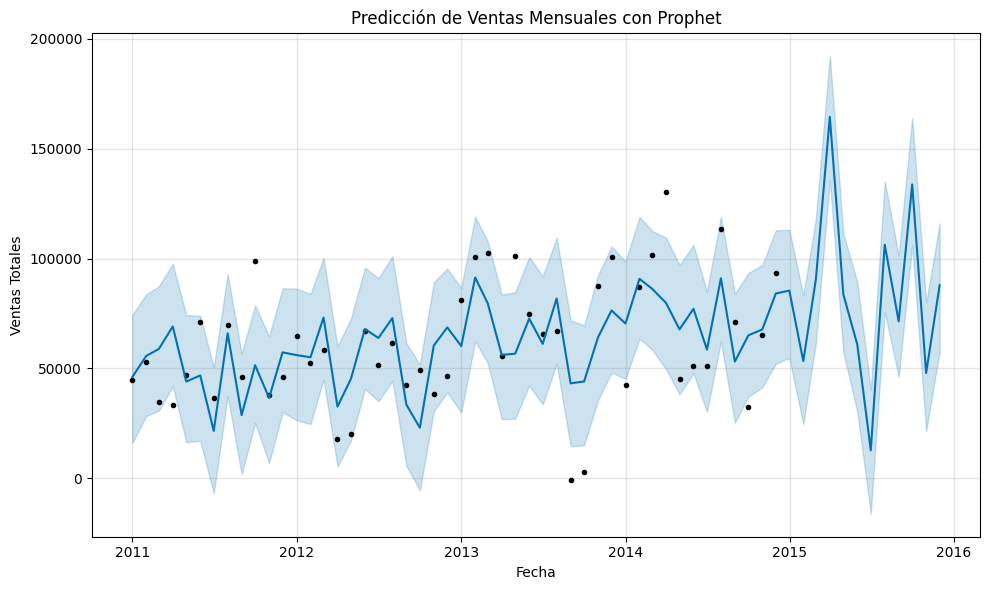

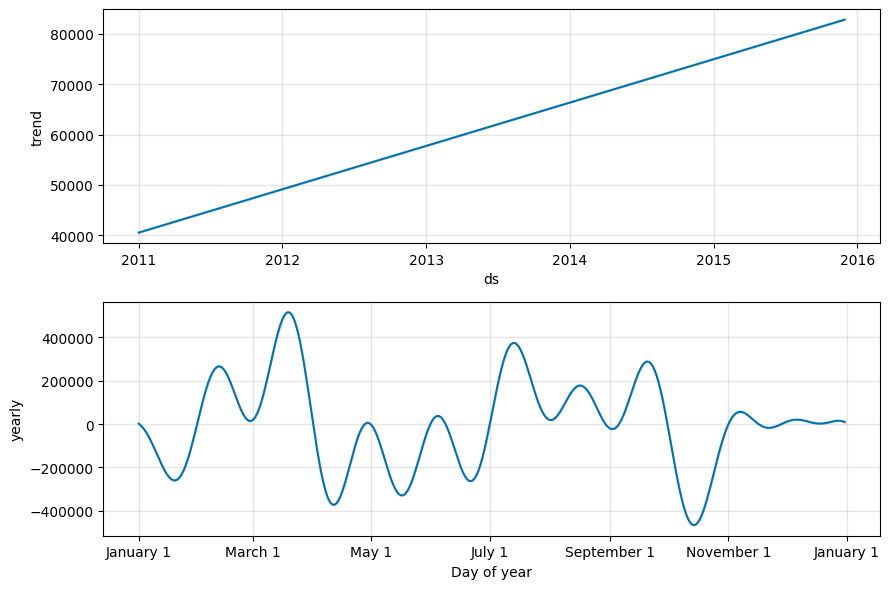

In [20]:
# Instalar Prophet si no est√° instalado
!pip install prophet -q

# Importar Prophet
from prophet import Prophet

# Agrupar ventas por mes
df["Order.Date"] = pd.to_datetime(df["Order.Date"], errors='coerce')
df["YearMonth"] = df["Order.Date"].dt.to_period("M")
df_prophet = df.groupby("YearMonth")["Sales.Total"].sum().reset_index()
df_prophet.columns = ["ds", "y"]
df_prophet["ds"] = df_prophet["ds"].dt.to_timestamp()  # ‚úÖ Conversi√≥n corregida

# Crear y entrenar modelo Prophet
modelo = Prophet()
modelo.fit(df_prophet)

# Crear dataframe futuro (12 meses m√°s)
futuro = modelo.make_future_dataframe(periods=12, freq='M')

# Realizar predicci√≥n
forecast = modelo.predict(futuro)

# Visualizaci√≥n de la predicci√≥n
fig1 = modelo.plot(forecast)
plt.title("Predicci√≥n de Ventas Mensuales con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.tight_layout()
plt.show()

# Visualizaci√≥n de componentes (tendencia y estacionalidad)
fig2 = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

## 19. Modelo de series temporales con Prophet

A diferencia del modelo anterior, Prophet est√° dise√±ado espec√≠ficamente para series temporales con estacionalidad y tendencia.

Aqu√≠ modelamos las ventas mensuales totales (`Sales.Total`) y proyectamos los pr√≥ximos 12 meses. El modelo se ajusta autom√°ticamente a los patrones de la serie, y permite observar la tendencia global y efectos estacionales.

Esta herramienta resulta muy √∫til para escenarios de planificaci√≥n financiera, campa√±as de marketing y log√≠stica.


##Conclusiones:
*   Prophet capt√≥ una tendencia general creciente en las ventas a lo largo del tiempo.
*   Tambi√©n reconoci√≥ cierta variabilidad mensual, pero no logra capturar bien los picos m√°s bruscos de ventas (como el de 2015).
*   El intervalo de confianza se ampl√≠a hacia el final, lo cual es esperable porque el modelo tiene m√°s incertidumbre al predecir m√°s lejos.

